# This notebook is dedicated to the integration of XAI technologies to the deep learning models
### MSC/DSA/134

In [1]:
# import required packages
import globals.torch_gpu_processing as torch_gpu_processing
import joblib
import globals.data_utils as data_utils
from globals.pandas_functions import *
from globals.explainers.shap_explainer_torch import SHAPExplainerTorch
from globals.explainers.lime_explainer_torch import LimeExplainerTorch

C:\Users\PM User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch_gpu_processing.shared_test_direct_ml_processing()

DirectML device: privateuseone:0
Test operation successful: [2. 4.]


True

In [3]:
# define base path
root_path = "data/processed/null_value_option_1_with_validation_set"

In [4]:
# get feature names
feature_names_json = root_path + "/dataset_feature_names.json"

import json
with open(feature_names_json, 'r') as f:
    feature_names = json.load(f)

print("Feature names loaded:")
print(feature_names)

Feature names loaded:
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'M4', 'M1_T', 'M2_T', 'M3_T', 'M6_T']


In [5]:
# define fitted models path
fitted_models_base = "models/deep_learning/"

In [6]:
# without PCA selected features
data_base_path = root_path + "/scaled_and_balanced"


X_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_train_balanced.csv")
X_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_validation_scaled.csv")
X_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_x_test_scaled.csv")

y_train = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_train_balanced.csv")
y_validation = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_validation.csv")
y_test = pd.read_csv(f"{data_base_path}/unified_transaction_data_option2_y_test.csv")

In [7]:
dataset_dimension("X_train", X_train)
dataset_dimension("X_test", X_test)

X_train dataset dimension: (683822, 26)
X_test dataset dimension: (118102, 26)


In [7]:
# view class distributions
data_utils.show_class_distribution(X_train, y_train.to_numpy().ravel(), "Class distribution of original dataset")
data_utils.show_class_distribution(X_test, y_test.to_numpy().ravel(), "Class distribution of test dataset")


Class distribution of original dataset:
  Total samples: 683822
  Y df samples:  [0 0 0 ... 1 1 1]
  Class 0 (non-fraud): 341911 (50.00%)
  Class 1 (fraud): 341911 (50.00%)

Class distribution of test dataset:
  Total samples: 118102
  Y df samples:  [0 0 1 ... 0 0 0]
  Class 0 (non-fraud): 113971 (96.50%)
  Class 1 (fraud): 4131 (3.50%)


### Set XAI Meta Data

In [7]:
# set XAI meta data
test_for_fraud = 1
interpretability_index = y_test.index[y_test["isFraud"] == test_for_fraud][0]
y_instance = y_test.loc[interpretability_index]
print(f"search index: {interpretability_index} \ny_instance: {y_instance}")

search index: 2 
y_instance: isFraud    1
Name: 2, dtype: int64


## 1. MLP Model

In [8]:
# load MLP model
mlp_model = joblib.load(fitted_models_base + "mlp_model.joblib")

### 1.1. MLP - SHAP Integration

In [9]:
shap_explainer = SHAPExplainerTorch(mlp_model, X_train, X_test, feature_names)
shap_explainer.explain()


Computing SHAP Explanations for PyTorch Model
Using DeepExplainer
Creating DeepExplainer...
    Using 100 background samples

    Explainer initialization time: 0.27 seconds

Calculating SHAP values for 20 test samples...
    SHAP values computation time: 0.27 seconds
  SHAP values shape: (20, 26, 1)



Generating SHAP Summary Plot (Bar)...


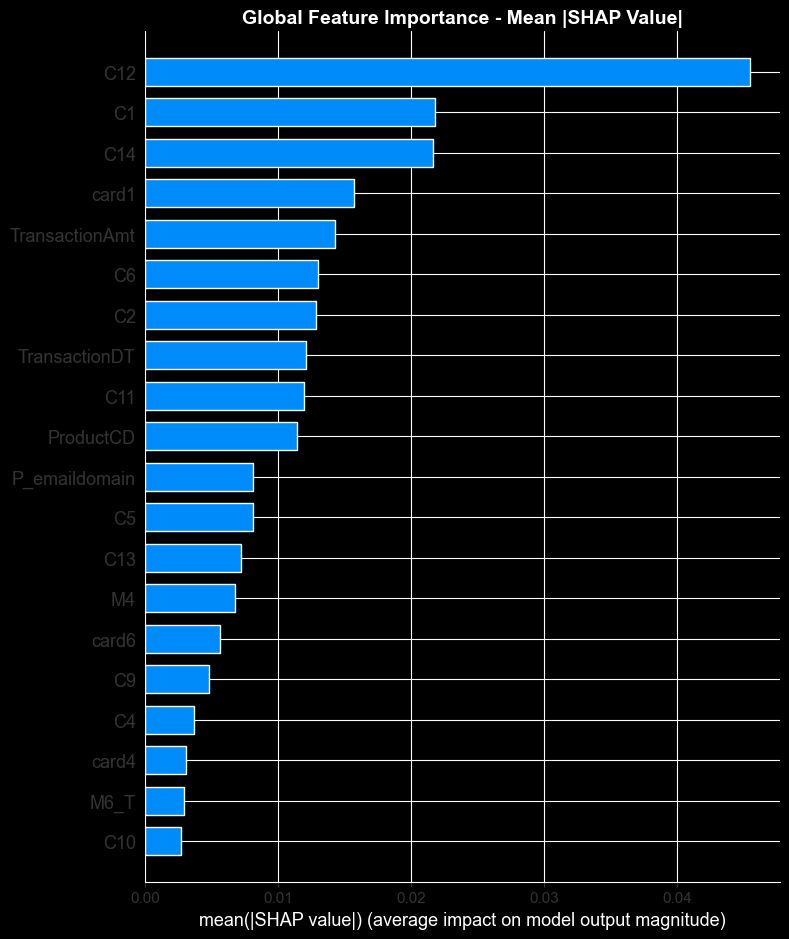

Generating SHAP Summary Plot (Dot)...


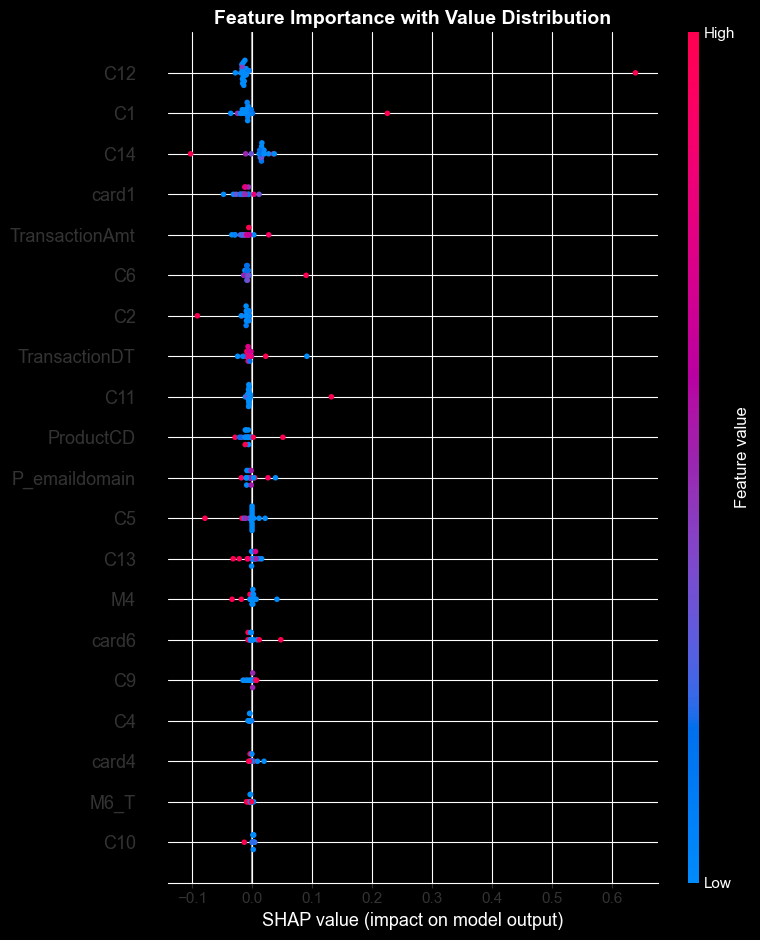

In [10]:
# show SHAP summary plot for global feature importance
shap_explainer.show_global_summary_plots()


SHAP Waterfall Plot for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0997
  SHAP values shape: (26,)
  Sum of SHAP values: 0.9003
  Prediction: 1.0000


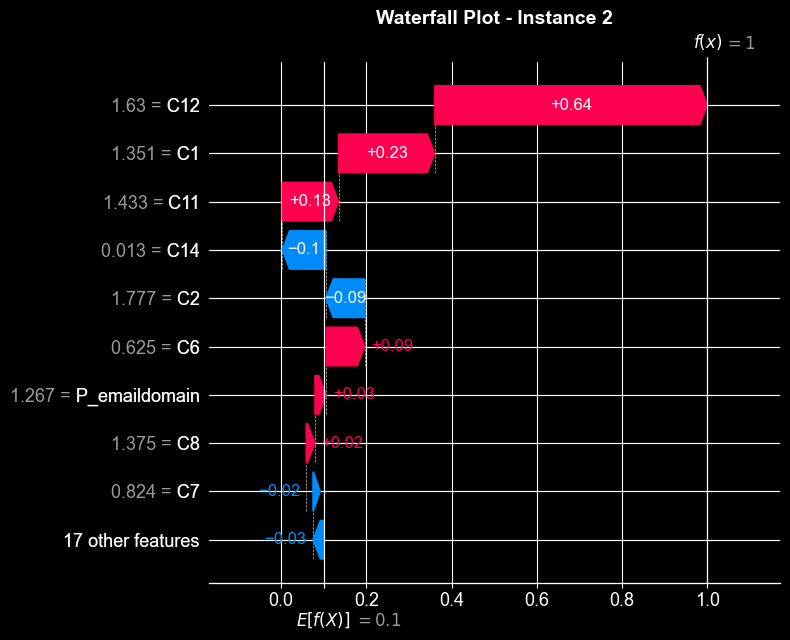

In [11]:
# show waterfall plot for the specific instance
shap_explainer.show_waterfall_plot(interpretability_index)

In [12]:
# get feature importance of the specific instance

# export shap values
xai_results_path = "xai_outputs/deep_learning/"
file_name = "mlp_shap_result.csv"

shap_explainer.get_feature_influence(interpretability_index,xai_results_path, file_name)


Detailed Feature Influences for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0997
  SHAP values shape: (26,)
  Sum of SHAP values: 0.9003
  Prediction: 1.0000

Top 15 Most Influential Features:
Dataset Feature Index  Feature Name  Feature Value  SHAP Value (Influence)
                   18           C12       1.630464                0.639655
                    7            C1       1.350552                0.225759
                   17           C11       1.433082                0.132367
                   20           C14       0.013112               -0.102503
                    8            C2       1.777337               -0.091261
                   12            C6       0.624841                0.090234
                    6 P_emaildomain       1.267098                0.026626
                   14            C8       1.374608                0.020459
                   13            C7       0.824051               -0.015753
                   16 

,Dataset Feature Index,Feature Name,Feature Value,SHAP Value (Influence)
18,18,C12,1.630464,0.639655
7,7,C1,1.350552,0.225759
17,17,C11,1.433082,0.132367
20,20,C14,0.013112,-0.102503
8,8,C2,1.777337,-0.091261
12,12,C6,0.624841,0.090234
6,6,P_emaildomain,1.267098,0.026626
14,14,C8,1.374608,0.020459
13,13,C7,0.824051,-0.015753
16,16,C10,0.495330,-0.012950


### 1.2. MLP - LIME Integration

Generating LIME Explainer (PyTorch)...
LIME Explainer initialization time: 3.69 seconds
Explaining instance 2 with LIME...
LIME explanation computation time: 0.91 seconds
LIME Explanation Plot:


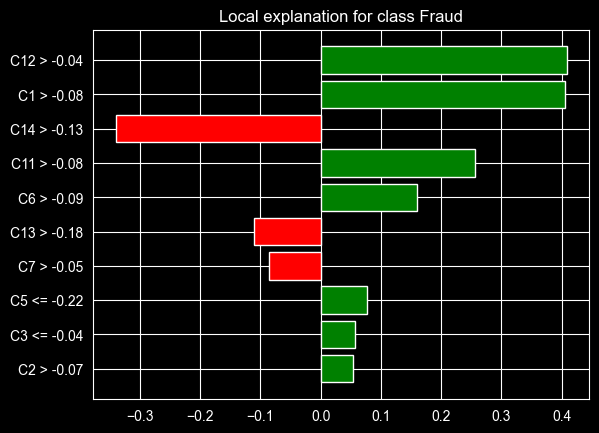

In [13]:
lime_explainer = LimeExplainerTorch(mlp_model, X_train, X_test, feature_names)
lime_explainer.init_lime_explainer()
lime_explainer.show_lime_explainer(instance_idx=interpretability_index)

## 2. AE Model

In [14]:
# load AE model
ae_model = joblib.load(fitted_models_base + "ae_model.joblib")

### 2.1. AE - SHAP Integration

In [15]:
ae_shap_explainer = SHAPExplainerTorch(ae_model, X_train, X_test, feature_names)
ae_shap_explainer.explain()

# TODO: fix issues here - currently the SHAP values are not being calculated correctly for the AE model, need to investigate and resolve this issue


Computing SHAP Explanations for PyTorch Model
Using DeepExplainer
Creating DeepExplainer...
    Using 100 background samples
    DeepExplainer issue: unrecognized nn.Module: SiLU
Using GradientExplainer (fallback – model has unsupported activations for DeepExplainer)
Creating GradientExplainer...
    Using 100 background samples


C:\Users\PM User\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:255: UserWarning: unrecognized nn.Module: SiLU
  warnings.warn(f"unrecognized nn.Module: {module_type}")



    Explainer initialization time: 33.54 seconds

Calculating SHAP values for 20 test samples...
    SHAP values computation time: 33.54 seconds
  SHAP values shape: (20, 26, 26)



Generating SHAP Summary Plot (Bar)...


D:\personal\studies\msc\Reserach\implementations\python\notebooks\globals\explainers\shap_explainer_torch.py:247: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


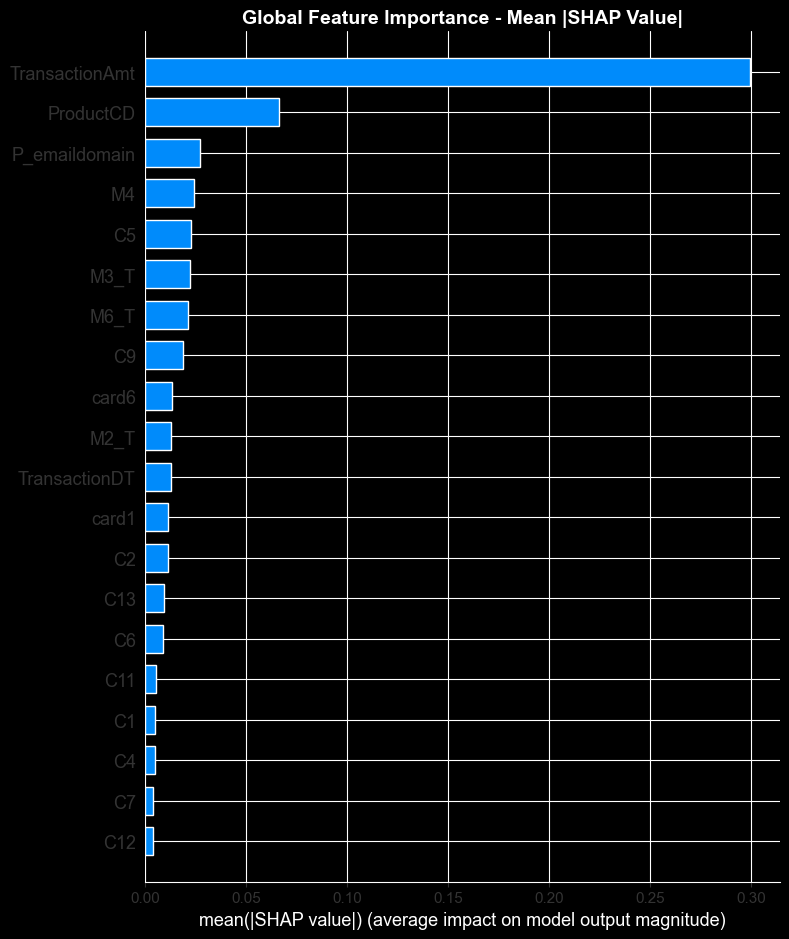

Generating SHAP Summary Plot (Dot)...


D:\personal\studies\msc\Reserach\implementations\python\notebooks\globals\explainers\shap_explainer_torch.py:261: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


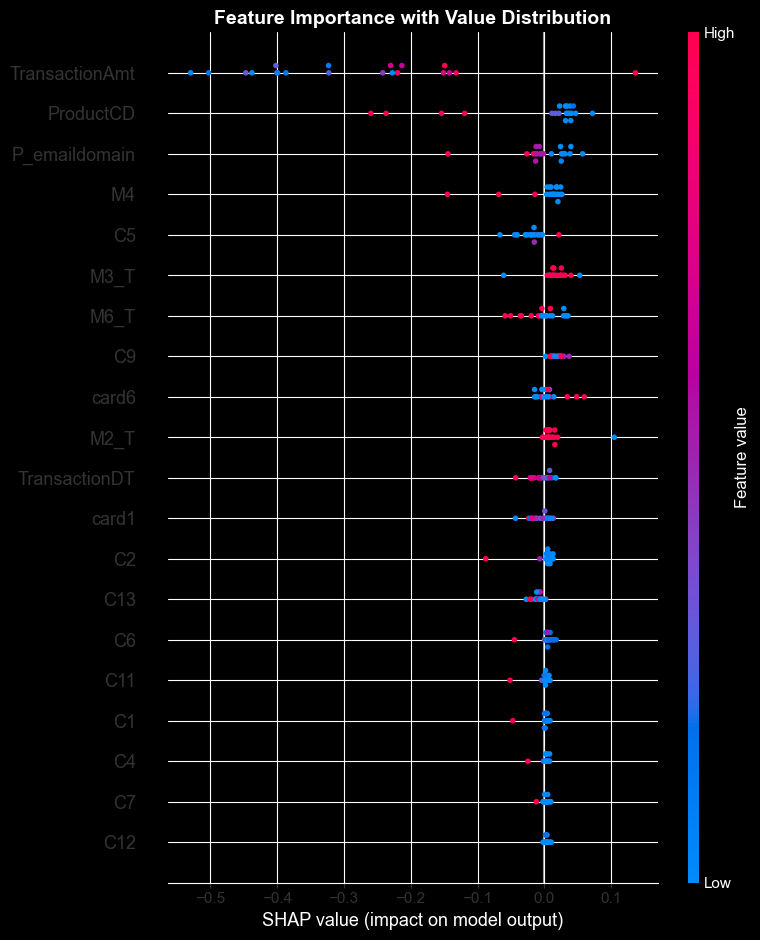

In [16]:
# show SHAP summary plot for global feature importance
ae_shap_explainer.show_global_summary_plots()


SHAP Waterfall Plot for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0338
  SHAP values shape: (26,)
  Sum of SHAP values: -0.7657
  Prediction: -0.7319


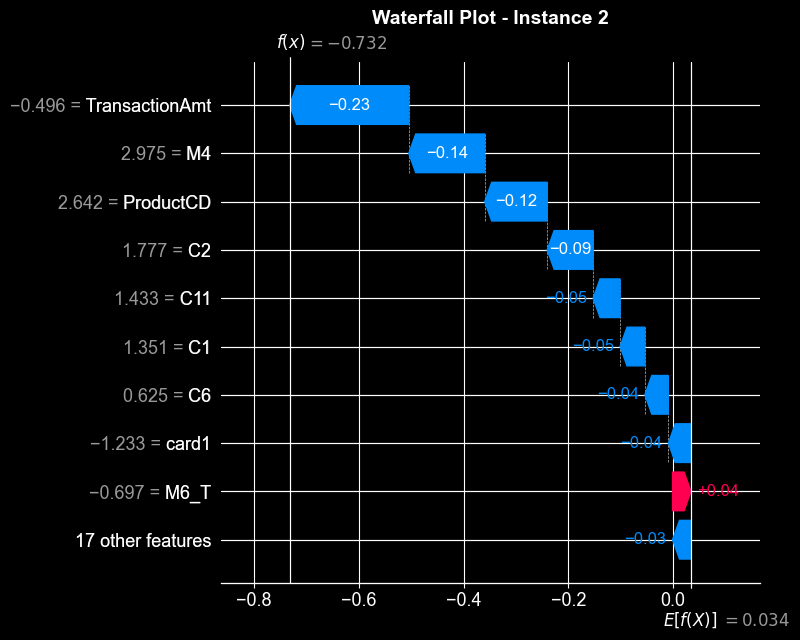

In [17]:
# show waterfall plot for the specific instance
ae_shap_explainer.show_waterfall_plot(interpretability_index)

In [18]:
# get feature importance of the specific instance

# export shap values
xai_results_path = "xai_outputs/deep_learning/"
file_name = "ae_shap_result.csv"

ae_shap_explainer.get_feature_influence(interpretability_index,xai_results_path, file_name)


Detailed Feature Influences for Instance 2

Extracting SHAP values for instance 2:
  Base value (expected): 0.0338
  SHAP values shape: (26,)
  Sum of SHAP values: -0.7657
  Prediction: -0.7319

Top 15 Most Influential Features:
Dataset Feature Index   Feature Name  Feature Value  SHAP Value (Influence)
                    1 TransactionAmt      -0.496461               -0.227278
                   21             M4       2.975260               -0.144973
                    2      ProductCD       2.642192               -0.119199
                    8             C2       1.777337               -0.087682
                   17            C11       1.433082               -0.051464
                    7             C1       1.350552               -0.047303
                   12             C6       0.624841               -0.044891
                    3          card1      -1.233142               -0.043205
                   25           M6_T      -0.696939                0.035230
          

,Dataset Feature Index,Feature Name,Feature Value,SHAP Value (Influence)
1,1,TransactionAmt,-0.496461,-0.227278
21,21,M4,2.975260,-0.144973
2,2,ProductCD,2.642192,-0.119199
8,8,C2,1.777337,-0.087682
17,17,C11,1.433082,-0.051464
7,7,C1,1.350552,-0.047303
12,12,C6,0.624841,-0.044891
3,3,card1,-1.233142,-0.043205
25,25,M6_T,-0.696939,0.035230
10,10,C4,0.720849,-0.024741


### 2.2. AE - LIME Integration

Generating LIME Explainer (PyTorch)...
LIME Explainer initialization time: 3.78 seconds
Explaining instance 2 with LIME...
LIME explanation computation time: 1.57 seconds
LIME Explanation Plot:


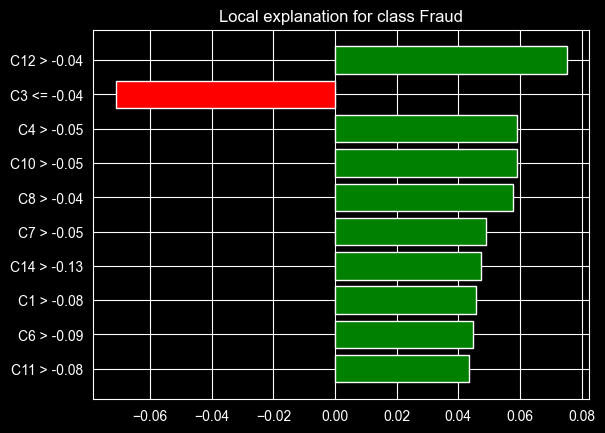

In [19]:
ae_lime_explainer = LimeExplainerTorch(ae_model, X_train, X_test, feature_names)
ae_lime_explainer.init_lime_explainer()
ae_lime_explainer.show_lime_explainer(instance_idx=interpretability_index)